In [13]:
import matplotlib.pyplot as plot
import pandas as pd
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch
from dgl.data import DGLDataset
import numpy as np
import torch.nn as nn
import torch
import itertools
import dgl.data
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from tqdm import tqdm

In [41]:
data = pd.read_csv("/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/df/old_500events_cluster.csv")

In [89]:
def process_df(df, cone_angle_deg=45):
    modified_df = df.copy()
    event_references = modified_df.groupby('event_idx').last()[['first hit x', 'first hit y']]
    modified_df['ModifiedTrueID'] = modified_df['trueID']
    
    for event_id in modified_df['event_idx'].unique():
        event_mask = modified_df['event_idx'] == event_id
        event_data = modified_df[event_mask]
        
        ref_x = event_references.loc[event_id, 'first hit x']
        ref_y = event_references.loc[event_id, 'first hit y']
        reference_angle = np.degrees(np.arctan2(ref_x, ref_y))
        hit_angles = np.degrees(np.arctan2(event_data['strip_x']*10, event_data['strip_y']*10))
        # Get the angular distance from the reference direction
        angles = np.abs(hit_angles - reference_angle)
        # Handle the wraparound at ±180 degrees
        angles = np.minimum(angles, 360 - angles)
        
        # Modify TrueID for points outside cone
        modified_df.loc[event_mask & (angles > cone_angle_deg), 'ModifiedTrueID'] = -1
    return modified_df

# Plot the data
modified_df = process_df(data, cone_angle_deg = 22)

In [106]:
class HitDataset(DGLDataset):
    def __init__(self, data, filter_events):
        self.data = data
        self.filter_events = filter_events
        super().__init__(name = "KLM_reco")
    def process(self):
        events_group = self.data.groupby("event_idx")
        self.labels = torch.empty(len(events_group))
        self.graphs = []
        it_idx = 0
        for event_idx in events_group.groups:
            curr_event = events_group.get_group(event_idx)
            nhits = len(curr_event)
            '''FIRST FILTER FOR EVENTS'''
            if(self.filter_events):
                ModifiedTrueID_unique = np.array(curr_event['ModifiedTrueID'].unique())
                valid_ModifiedTrueID_unique = ModifiedTrueID_unique[ModifiedTrueID_unique != -1]
                #skip events with multiple valid trueIDs
                if(len(valid_ModifiedTrueID_unique) > 1):
                    continue
            
                #skip events with no valid ModififiedTrueIDs
                if(len(valid_ModifiedTrueID_unique) == 0):
                    continue
            #Fully connected network of hits
            if(nhits <2):
                sources, destinations = [],[]
            else:
                sources, destinations = zip(*[
                        (i, j) for i, j in itertools.product(range(nhits), range(nhits))
                        if i != j
                ])
            g = dgl.graph((sources, destinations), num_nodes=nhits)

            if(nhits < 2):
                g = dgl.add_self_loop(g)
            #Want to predict momentum/energy
            label = torch.tensor(curr_event["P"].to_numpy()[0])
            self.labels[it_idx] = label

            #Node features: strip position and SiPM output

            
            '''TO RETAIN STRUCTURE OF FEATURES:'''
            
            #strip_pos has shape nhits x 2
            strip_pos = torch.tensor(np.stack((curr_event["strip_x"].to_numpy(),curr_event["strip_y"].to_numpy()),axis = 1))
            #SiPM_timing has shape nhits x 2 (SiPMs are together in one tensor)
            SiPM_timing = torch.tensor(np.stack((curr_event["Time1"].to_numpy(),curr_event["Time2"].to_numpy()),axis = 1))
            SiPM_charge = torch.tensor(np.stack((curr_event["Charge1"].to_numpy(),curr_event["Charge2"].to_numpy()),axis = 1))
           
            g.ndata["features"] = torch.stack((strip_pos,SiPM_timing,SiPM_charge),dim=1)
            
            '''FLATTENED VERSION'''
            #THIS VERSION KEEPS FEATURES IN ONE DIMENSION
            feats = np.stack((
                curr_event["strip_x"].to_numpy(),curr_event["strip_y"].to_numpy(),
                curr_event["Time1"].to_numpy(),curr_event["Time2"].to_numpy(),
                curr_event["Charge1"].to_numpy(),curr_event["Charge2"].to_numpy()
            ),axis = -1)
            g.ndata["features"] = torch.tensor(feats)
    

            #add graph to dataset
            self.graphs.append(g)
            it_idx += 1
        self.dim_nfeats = self.graphs[0].ndata["features"].shape[1]

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

dataset = HitDataset(modified_df,True)

In [108]:
from dgl.nn import GraphConv


class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes = 1):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata["h"] = h
        return dgl.mean_nodes(g, "h")

In [109]:
dataset[0][0]

Graph(num_nodes=24, num_edges=552,
      ndata_schemes={'features': Scheme(shape=(6,), dtype=torch.float64)}
      edata_schemes={})

In [110]:
# Create the model with given dimensions
model = GCN(dataset.dim_nfeats, 16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [111]:
test_frac = 0.8
test_start = int(np.floor(len(dataset) * 0.8))
train_dataset = dataset[0:test_start]
test_dataset = dataset[test_start:]

In [117]:
criterion = nn.MSELoss()
n_epochs = 30
losses = []
for epoch in tqdm(range(n_epochs)):
    epoch_losses = []
    for graph_idx in range(len(train_dataset[0])):
        try:
            graph = train_dataset[0][graph_idx]
            label = train_dataset[1][graph_idx]
            pred = model(graph, graph.ndata["features"].float())
            loss = criterion(pred.squeeze(0), label.unsqueeze(-1))
            epoch_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        except:
            print(graph)
    losses.append(np.mean(epoch_losses))

100%|██████████| 30/30 [00:02<00:00, 10.27it/s]


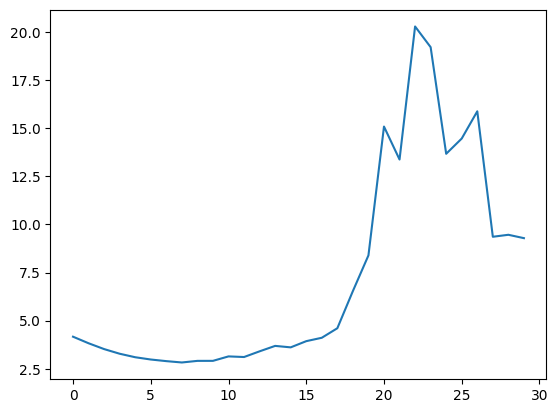

In [118]:
plot.plot(losses)

In [119]:
truths = []
preds = []
sqerrors = []
for graph_idx in range(len(test_dataset[0])):
    graph = test_dataset[0][graph_idx]
    truth = test_dataset[1][graph_idx].detach()
    pred = model(graph, graph.ndata["features"].float()).detach()
    truths.append(truth)
    preds.append(pred)
    sqerrors = pow(truth - pred,2)
sqerrors = np.array(sqerrors)
rmse = np.sqrt(np.mean(sqerrors))

In [120]:
rmse

np.float32(0.602939)

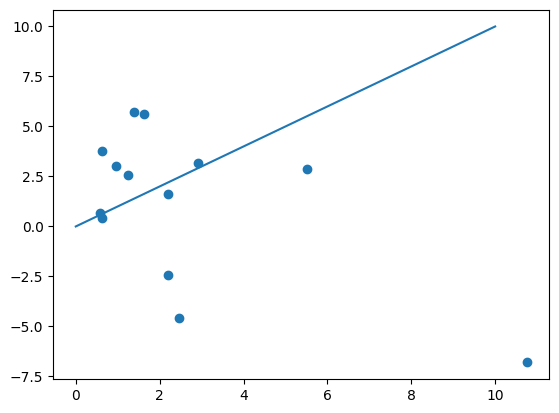

In [121]:
plot.scatter(truths,preds)
plot.plot([0,10],[0,10])